# Homework 5: Taming text

In [130]:
%matplotlib inline
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from wordcloud import WordCloud
from PIL import Image

import nltk
import string

import pycountry

from tqdm import tqdm_notebook
import re

from ipywidgets import FloatProgress
from IPython.display import display


import itertools
import gensim

import pyLDAvis.gensim as gensimvis
import pyLDAvis

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/pierre/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/pierre/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/pierre/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/pierre/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/pierre/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/pierre/an

# Part 1 : Word Cloud
In this first part, we want to generate 2 wordclouds based on the content of Mrs Clinton's emails.<br/>
- The 1st wordcloud will be built on the raw body of extracted emails.
- The 2nd one will be built on emails after they underwent a standard pre-processing pipeline.

## 1 - Load Data

In [2]:
path = 'hillary-clinton-emails/'
emails = pd.read_csv(path + "Emails.csv")
print(emails.shape)
emails.head()

(7945, 22)


,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


First of all, let's observe our corpus :
- **Unit document** : An email
- **Corpus size** : 7945 documents
- **Language** : English
- **Character set** ; UTF-8

It seems that we are provided with either the raw text file or an "attempt at extracting the body" of the message. We compare them on one instance to understand them better.

In [3]:
print(emails.head()["RawText"][1][0:500])

UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739546
Date: 05/13/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Attachments:
B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
CONFIDENTIAL
March 3, 2011
For: Hillary
From: Si


In [4]:
print(emails.head()["ExtractedBodyText"][1])

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary


<table>
<tr>
    <th>Raw Data</th>
    <th>Extracted Data</th>
</tr>
<tr>
    <td>We're assured to get all the all emails, and all the informations</td>
    <td>Some mails (1203) are missing, and concerning the remaining mails, we may have lost information</td>
</tr>
<tr>
    <td>We may process a same mail several time (and give a bigger weight to the information it contains)</td>
    <td>Each mail is unique</td>
</tr>

</table>

It's risky but we choose to work with the raw emails. As we are insterested in the importance of each word in the corpus, we can concatenate it in a single string :

In [47]:
emails_rawtext = emails["RawText"]
raw_corpus = emails_rawtext.str.cat(sep=" ")

## 2 - First wordcloud

Defining the wordcloud generation

In [48]:
def generate_wordcloud(text):
    return WordCloud(background_color="white").generate(text)

Plot wordcloud for raw corpus

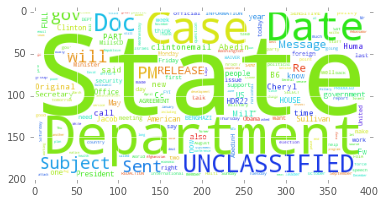

In [49]:
raw_wordcloud = generate_wordcloud(raw_corpus)
img1 = plt.imshow(raw_wordcloud)
plt.show()

## 3 - Pre-processing pipeline

We apply a standard pre-processing pipeline to the corpus : Tokenization, Normalization, Stop-words removal and Lemmatization.
- **Tokenization and Normalization**

**Tokenization** : Split the string-corpus into a list of tokens
**Normalization** : Try to find a unity within word, and remove noisy characters
    - Email adress removal : We are not interested in the mail adress but in the mail content
    - Replace apostrophes by whitespaces
    - Put tokens into lowercase : We can loose some information (ex: "Windows" => "windows") but it enables to group identical words.
    - Remove ponctuation-words 
    - Remove ponctuation within words : (ex: "un-discriminatory" => "undiscriminatory")
    - Remove digits : Digits can be useful, especially for dates (imagine a conversation about the 7/01/2015 in France), but in this case, digits are mostly used to mention the email's date (in which we are not interested)


- **Stop-word removal**

We first build a stop-list, composed of irrelevant words (often very common words), and all single letters, except H, because it was used as short for Hillary during the campaign:

In [61]:
def get_stop_words():
    stop_list = nltk.corpus.stopwords.words('english') # Pre-established stop-list
    
    days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    months = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", 
              "december"]
    time = ['am', 'pm', "year", "month", "week", "day", "hour", "minute", "sec", "today", "tomorrow", "yesterday"]
    mail_voc = ['unclassified', 'send', 'date', 're', "doc", "message", "b6", "original", "case", "us", "from", "sent", "to", 
                "subject", "attachments", "cc", "fw", "nt"]
    recurrent_words = ["state", "department", "call", "new", "gov", "release", "part", "in", "no", "gov", "time","say", 
                       "stategov", "would", "say", "also", "go", "want", "make", "know", "us"]
    numbers = ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve"]
    letters = ["a", "b", "c", "d", "e", "f", "g", "i", "j", "k", "l", 
             "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
    add_stopwords =  days + months + time + mail_voc + recurrent_words + numbers + letters
    
    return stop_list + add_stopwords

def stopword_removal(tokens):
    stop_list = get_stop_words()
    filtered = [word for word in tokens if word not in stop_list] # Remove stop-words
    
    return filtered

- **Lemmatization**

Lemmatization enables to build equivalence classes between similarly constructed tokens, which are likely to have similar semantic sense. <br/>
It identifies a canonical representative for a set of related word forms.<br/>
However, this method isn't infallible : 
    - some similar words can be attributed different representative,
    - some different words (in terms of semantic sense) can be attributed a same representative.

In [65]:
def preprocessing(raw, add_stopwords=[], verbose=False):
    # Tokenization
    if verbose:
        print("Tokenization...")
    punctuations = list(string.punctuation)
    tokens = nltk.word_tokenize(raw)
    tokenized = [token.lower() for token in tokens if token not in punctuations]
    
    # Stopword removal
    if verbose:
        print("Stopword removal...")
    filtered = stopword_removal(tokenized)
    
    # Lemmatisation
    if verbose:
        print("Lemmatization...")
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    #lemmatized = [wnl.lemmatize(word) for word in filtered]
    lemmatized = [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in nltk.pos_tag(filtered)]
    
    return lemmatized

In [79]:
#if you want to regenerate the processed text file, uncomment this first one. Otherwise just reload what we saved
"""
processed_corpus = preprocessing(raw_corpus, get_stop_words(), verbose=True)
digits = re.compile(r'[\'-.?!,":;()|0-9]')
processed_corpus = [digits.sub("", str(word)) for word in processed_corpus]   
processed_corpus = list(filter(None, processed_corpus)) # remove empty strings
processed_corpus = stopword_removal(processed_corpus) # some words have been lemmatized to stopwords
processed_corpus = [word for word in processed_corpus if word not in ["``", "//", "_", "-"]]
"""
preprocessed_corpus = [line.rstrip('\n') for line in open('processed_corpus.txt')]

In [80]:
corpus_file = open("processed_corpus.txt", 'w')
for word in processed_corpus:
    corpus_file.write("%s\n" % word)
corpus_file.close()

## 4 - Second Wordcloud
Let's build our second word cloud, based on the pre-processed corpus :

In [81]:
def generate_wordcloud2(text):
    mask = np.array(Image.open("onlymask.jpg"))
    return WordCloud(background_color="white", mask=mask).generate(text)

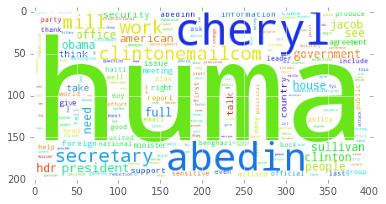

In [82]:
corpus_str = ' '.join(processed_corpus)
processed_wordcloud = generate_wordcloud(corpus_str)
img2 = plt.imshow(processed_wordcloud)
plt.show()

We can also plot the frequence of the most employed words :

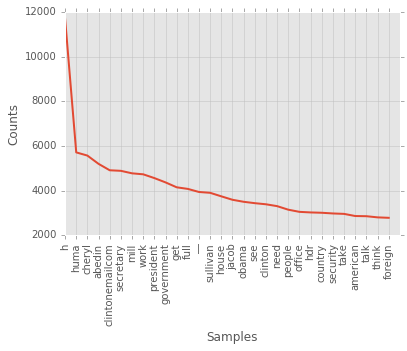

In [83]:
fd = nltk.FreqDist(processed_corpus)
fd.plot(30, cumulative=False)

We indeed see that different words appear. What is not suprising, auto generated words and generic ones would appear more frequently in the non processed corpus. After preprocessing, the second most appearing token is a name: Huma Abedin. Important figure in the Democratic Party (vice chairwoman of 2016's campaign), she's nicknamed Hillary Clinton's second daughter.
https://fr.wikipedia.org/wiki/Huma_Abedin
The first is H, for Hillary.

From the two word clous, it now seems clear that without preprocessing, we could not run a precise data analysis on the corpus.

From the frequency distribution, we see that we are out of Zipf's law, since the distribution seems linear (when we remove H).

# Part 2 : Sentiment analysis by country

In this second part, we will summarize the perception of the different countries following this process :
- Find all the mentions of world countries in each mail
- Perform sentiment analysis on every mail (using different methods)
- Conclude about the sentiment associated to each country (averaging their scores)

The first question that arises is : should we work on raw data or extracted data?

<table>
<tr>
    <th>Raw Data</th>
    <th>Extracted Data</th>
</tr>
<tr>
    <td>As we have access to the whole conversation, we are more likely to find what country is the conversation about. We can then get the vibe about a given country.</td>
    <td>We expect many mails will have no country mentions in them.</td>
</tr>
<tr>
    <td>We may process a same mail several time (and give it a bigger weight)</td>
    <td>Each mail is unique</td>
</tr>
</table>

Again, it makes sense to work with the raw text.

In [85]:
#there are 4 possible denominations, eventhough upon further reflexion, official_name is often several words so it will never match
countries = pd.DataFrame(columns=['alpha_2', 'alpha_3', 'name', 'official_name'])
country = list(pycountry.countries)[0]

for country in list(pycountry.countries):
    try:
        a3 = country.alpha_3
    except (AttributeError):
        a3 = np.nan
    try:
        offi = country.official_name
    except (AttributeError):
        offi = np.nan
    countries.loc[country.numeric] = [country.alpha_2, a3, country.name, offi]
countries = countries.apply(lambda x: x.str.lower())    

def country_mentions(text):
    matches = []
    #mask here is a data frame of boolean values
    mask = countries.isin(text)
    indices = mask[mask.any(axis=1)].index.values
    country_mentions = countries.loc[indices]["name"]
        
    return country_mentions

We want to apply the preprocessing function to each email separately

In [86]:
Processed_Text = emails["RawText"].apply(lambda x: preprocessing(x, add_stopwords=stopwords))

In [87]:
import nltk.sentiment
sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def sentiment_polarity(sentence):
    return sid.polarity_scores(sentence)["compound"]


In [88]:
sentiment = pd.Series([])
mentions = pd.Series([])

def build_sentiment_matrix(Processed_Text):
    for i in range(len(Processed_Text)):
            mentions_list = country_mentions(Processed_Text[i])
            text_local = ' '.join(Processed_Text[i])
            sentiment_local = sentiment_polarity(text_local)
            if i%500 == 0:
                print(i)
            for j in range(len(mentions_list)):
                mentions[len(mentions)+1] = mentions_list[j]
                sentiment[len(sentiment)+1] = sentiment_local
    return pd.concat([sentiment, mentions], axis=1)#.reset_index()

In [89]:
#this was necessary but is super super duper long
#sentiment_matrix = build_sentiment_matrix(Processed_Text)
#sentiment_matrix.to_csv('sentiment_matrix')
sentiment_matrix = pd.read_csv("sentiment_matrix", index_col=0)


In [90]:
sentiment_matrix.columns = ["sentiment", "country"]
sentiment_by_country = sentiment_matrix.groupby("country").mean()
sentiment_by_country.sort_values(by="sentiment", inplace=True)
#counting the number of appearances of each country in the raw text to filter them
sentiment_by_country["appearances"] = sentiment_matrix.groupby("country").count() 

sentiment_by_country.head(13)


,sentiment,appearances
country,,
sri lanka,-0.997200,1
djibouti,-0.997200,1
swaziland,-0.987000,1
south sudan,-0.901900,1
"taiwan, province of china",-0.747400,1
saint kitts and nevis,-0.735100,1
maldives,-0.486350,4
"korea, democratic people's republic of",-0.195800,2
antarctica,-0.084373,15


We only want to count countries appearing more than a number of times, so that the analysis makes sense statistically. Right above, we see that all countries being linked to a negative sentiment analysis appear very rarely in the emails. After trial and error, we found out that selecting the ones that appeared more than a hundred times gives a readable plot. Depending on the further analysis we may want to run, we could adjust this value to a more precisely calculated one.

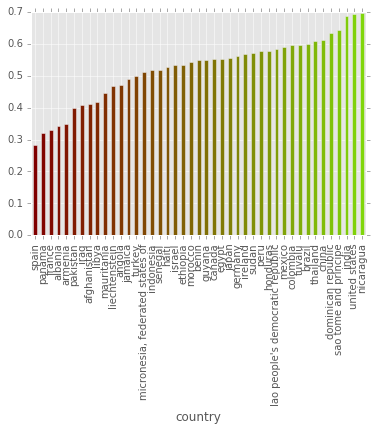

In [127]:
sentiment_by_country_to_plot = sentiment_by_country[sentiment_by_country["appearances"]>100]["sentiment"]
from itertools import cycle, islice

my_colors = [(0.5, x/50.0,  x/1000) for x in range(len(sentiment_by_country_to_plot))]

sentiment_by_country_to_plot.plot(kind="bar", stacked=True, color=my_colors)
plt.show()

This result is quit interesting. Other than a plateau for most countries, we see at the very top of opinions the U.S.A, Nicaragua and India. On the other side, we see Spain and France being less positively linked in these emails than Iraq, Afghanistan and Libya.

# Part 3 : Topic Modeling
http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html

## Dictionary

In [141]:
# Build dictonary
extracted_mails = [line.rstrip('\n') for line in open('processed_corpus.txt')]

%time id2word_mail = gensim.corpora.Dictionary(extracted_mails)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 35.3 µs


## Vectorization

In [142]:
def iter_emails(mails):
    for mail in mails:
        yield mail

In [143]:
class EmailsCorpus(object):
    
    def __init__(self, dump_file, dictionary, clip_docs=None):
        self.dump_file = dump_file
        self.dictionary = dictionary
        self.clip_docs = clip_docs
    
    def __iter__(self):
        for tokens in itertools.islice(iter_emails(self.dump_file), self.clip_docs):
            yield self.dictionary.doc2bow(tokens)
    
    def __len__(self):
        return self.clip_docs

In [144]:
# create a stream of bag-of-words vectors
mails_corpus = EmailsCorpus(extracted_mails, id2word_mail)

In [145]:
gensim.corpora.MmCorpus.serialize('SerializedCorpus.mm', mails_corpus)

## Model

In [146]:
lda = gensim.models.ldamodel.LdaModel(mails_corpus, num_topics=10, id2word=id2word_mail)

ValueError: cannot compute LDA over an empty collection (no terms)

In [147]:
lda.show_topics()

NameError: name 'lda' is not defined

## Visualization

In [148]:
SerializedCorpus = gensim.corpora.MmCorpus('SerializedCorpus.mm')
visualization = gensimvis.prepare(lda, SerializedCorpus, id2word_mail) # model, corpus, dic
pyLDAvis.display(visualization)

NameError: name 'lda' is not defined

In [149]:
pyLDAvis.save_html(visualization,'LDA_Visualization_10_topics.html')

NameError: name 'visualization' is not defined